In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

### Data

In [2]:
df = pd.read_csv("data/data_validation_python.csv")

In [3]:
df.columns

Index(['date_current', 'ticker', 'expiration_date', 'days_to_expiry',
       'option_id', 'option_type', 'strike_price', 'bid_price', 'option_price',
       'mid_price', 'ask_price', 'implied_volatility', 'volume',
       'open_interest', 'stock_price', 'dividend_yield', 'rate', 'delta',
       'gamma', 'theta', 'vega', 'rho', 'vanna', 'vomma', 'charm', 'veta',
       'speed', 'zomma', 'color', 'ultima', 'mnyness', 'last', 'bid', 'mid',
       'ask', 'implied vol using last trade price',
       'volume, if no volume traded field will display most recent volume on whatever day it last traded',
       'DELTA_MID', 'GAMMA_LAST', 'THETA_LAST', 'VEGA_LAST', 'RHO_LAST',
       'Stock Price'],
      dtype='object')

### Implied Volatility

In [4]:
cols = ['implied_volatility', 'implied vol using last trade price']
item = "IV"

tmp = df[cols]
tmp.columns = ['yh', 'bbg']
tmp = tmp.dropna()

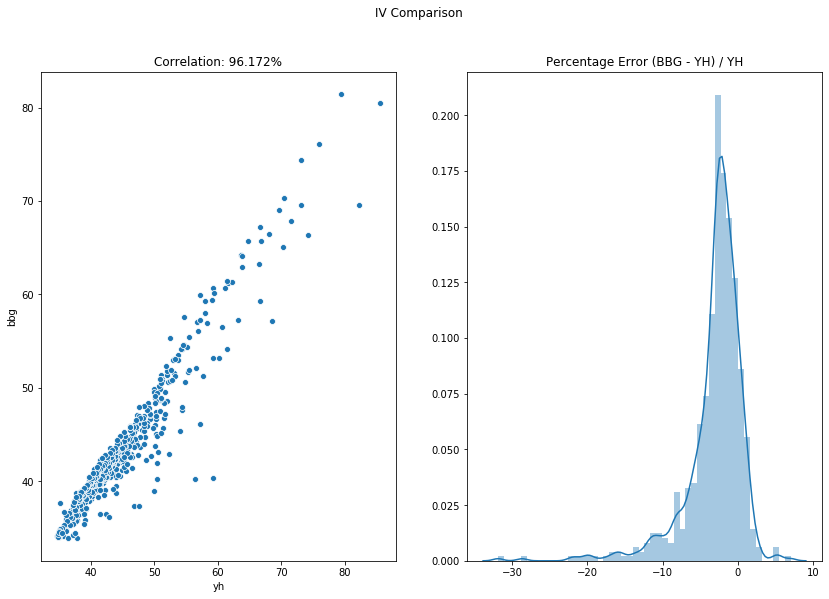

In [5]:
f, ax = plt.subplots(1, 2, figsize=(14, 9))
f.suptitle(f"{item} Comparison")

sns.scatterplot(x='yh', y='bbg', data=tmp, ax=ax[0])
ax[0].set_title(f"Correlation: {round(100 * tmp.yh.corr(tmp.bbg), 3)}%")

sns.distplot(100 * tmp.diff(axis=1).bbg / tmp.yh, ax=ax[1])
ax[1].set_title("Percentage Error (BBG - YH) / YH")
plt.savefig("plots/iv_comparison.png")

### IV Solver Using Black Scholes

In [6]:
def blackscholes(S, K, T, v, r, q, t):
    
    d1 = np.log(S / K) + (r - q + v * v * 0.5) * T
    d1 /= v * np.sqrt(T)
    d2 = d1 - v * np.sqrt(T)
    
    price = t * S * np.exp(-q * T) * norm.cdf(t * d1)
    price -= t * K * np.exp(-r * T) * norm.cdf(t * d2)
    
    return price

def vega(S, K, T, v, r, q, t):
    
    d1 = np.log(S / K) + (r - q + v * v * 0.5) * T
    d1 /= v * np.sqrt(T)
    
    return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

In [7]:
M = ((df.bid_price + df.ask_price) * 0.5).values
L = df.option_price.values
S = df.stock_price.values
K = df.strike_price.values
T = df.days_to_expiry.values / 365
v = df.implied_volatility.values / 100
r = df.rate.values / 100
q = df.dividend_yield.values / 100
t = df.option_type.map({"C" : 1, "P" : -1})

In [8]:
v = pd.Series([0.5]*len(df))

In [21]:
e = (blackscholes(S, K, T, v, r, q, t) - L) / vega(S, K, T, v, r, q, t)
v = v - e
v

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
692    0.538614
693    0.470298
694    0.427410
695    0.481874
696    0.565491
Length: 697, dtype: float64

### Implied Volatility

In [22]:
cols = ['implied_volatility', 'implied vol using last trade price']
item = "IV"

tmp = df[cols]
tmp.columns = ['yh', 'bbg']
tmp['yh'] = v.values * 100
tmp = tmp.dropna()

/home/zquantz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


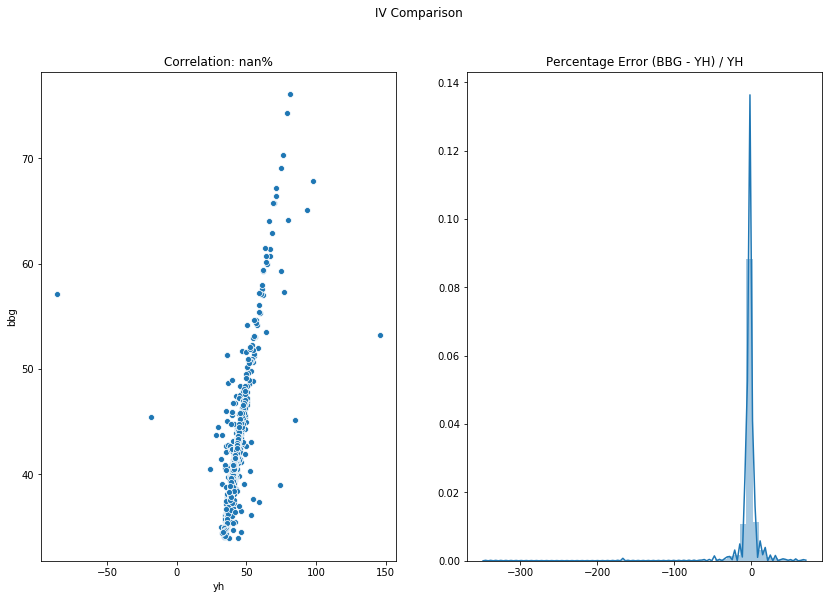

In [23]:
f, ax = plt.subplots(1, 2, figsize=(14, 9))
f.suptitle(f"{item} Comparison")

sns.scatterplot(x='yh', y='bbg', data=tmp, ax=ax[0])
ax[0].set_title(f"Correlation: {round(100 * tmp.yh.corr(tmp.bbg), 3)}%")

sns.distplot(100 * tmp.diff(axis=1).bbg / tmp.yh, ax=ax[1])
ax[1].set_title("Percentage Error (BBG - YH) / YH")
plt.savefig("plots/iv_comparison_newton_last.png")

### IV Solver Using Black Scholes

In [24]:
def blackscholes(S, K, T, v, r, q, t):
    
    d1 = np.log(S / K) + (r - q + v * v * 0.5) * T
    d1 /= v * np.sqrt(T)
    d2 = d1 - v * np.sqrt(T)
    
    price = t * S * np.exp(-q * T) * norm.cdf(t * d1)
    price -= t * K * np.exp(-r * T) * norm.cdf(t * d2)
    
    return price

def vega(S, K, T, v, r, q, t):
    
    d1 = np.log(S / K) + (r - q + v * v * 0.5) * T
    d1 /= v * np.sqrt(T)
    
    return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

In [25]:
M = ((df.bid_price + df.ask_price) * 0.5).values
L = df.option_price.values
S = df.stock_price.values
K = df.strike_price.values
T = df.days_to_expiry.values / 365
v = df.implied_volatility.values / 100
r = df.rate.values / 100
q = df.dividend_yield.values / 100
t = df.option_type.map({"C" : 1, "P" : -1})

In [26]:
v = pd.Series([0.5]*len(df))

In [40]:
e = (blackscholes(S, K, T, v, r, q, t) - M) / vega(S, K, T, v, r, q, t)
v = v - e
v

0      0.906933
1      0.872981
2      0.775673
3      0.772674
4      0.787384
         ...   
692    0.369782
693    0.365265
694    0.356438
695    0.352142
696    0.347194
Length: 697, dtype: float64

### Implied Volatility

In [41]:
cols = ['implied_volatility', 'implied vol using last trade price']
item = "IV"

tmp = df[cols]
tmp.columns = ['yh', 'bbg']
tmp['yh'] = v.values * 100
tmp = tmp.dropna()

/home/zquantz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


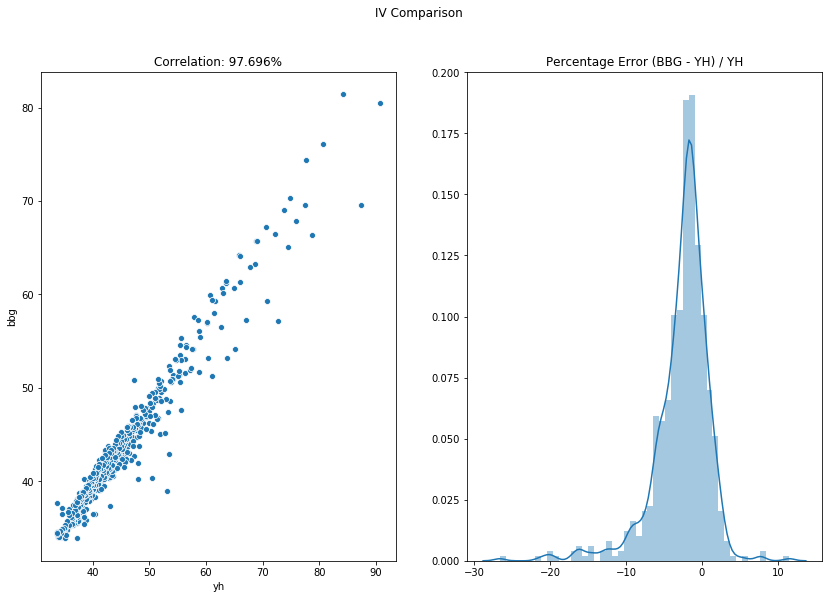

In [42]:
f, ax = plt.subplots(1, 2, figsize=(14, 9))
f.suptitle(f"{item} Comparison")

sns.scatterplot(x='yh', y='bbg', data=tmp, ax=ax[0])
ax[0].set_title(f"Correlation: {round(100 * tmp.yh.corr(tmp.bbg), 3)}%")

sns.distplot(100 * tmp.diff(axis=1).bbg / tmp.yh, ax=ax[1])
ax[1].set_title("Percentage Error (BBG - YH) / YH")
plt.savefig("plots/iv_comparison_newton_mid.png")

### Mid Price

In [43]:
cols = ['mid_price', 'mid']
item = "Mid Price"

tmp = df[cols]
tmp.columns = ['yh', 'bbg']
tmp = tmp.dropna()

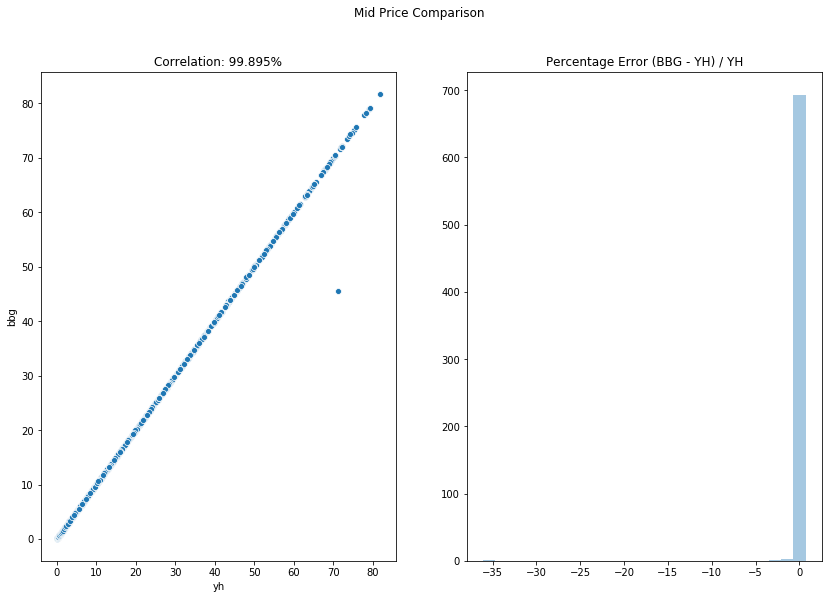

In [44]:
f, ax = plt.subplots(1, 2, figsize=(14, 9))
f.suptitle(f"{item} Comparison")

sns.scatterplot(x='yh', y='bbg', data=tmp, ax=ax[0])
ax[0].set_title(f"Correlation: {round(100 * tmp.yh.corr(tmp.bbg), 3)}%")

sns.distplot(100 * tmp.diff(axis=1).bbg / tmp.yh, kde=False, ax=ax[1])
ax[1].set_title("Percentage Error (BBG - YH) / YH")
plt.savefig("plots/mid_price_comparison.png")

### Delta

In [45]:
cols = ['delta', 'DELTA_MID']
item = "Delta"

tmp = df[cols]
tmp.columns = ['yh', 'bbg']
tmp['bbg'] = tmp.bbg.str.replace("%", "").astype(float) * 0.01
tmp = tmp.dropna()

/home/zquantz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


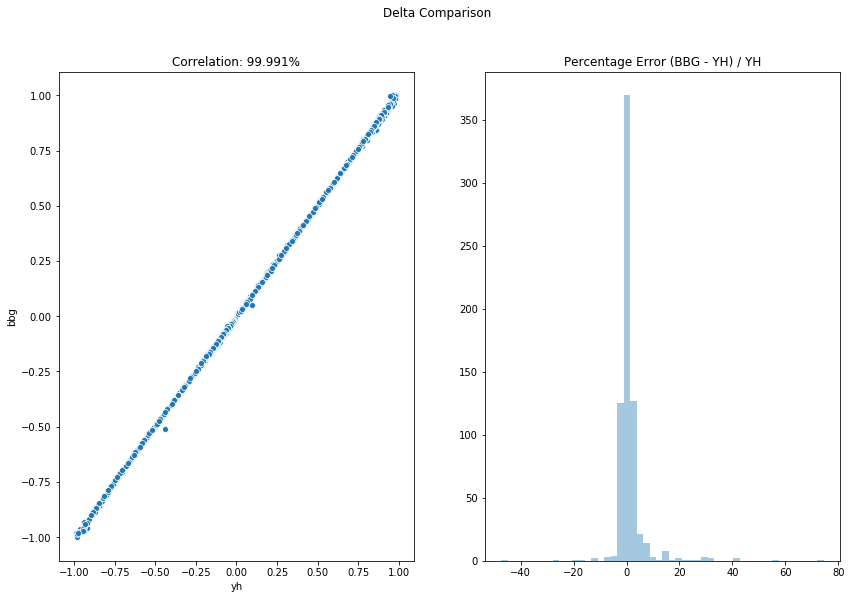

In [46]:
f, ax = plt.subplots(1, 2, figsize=(14, 9))
f.suptitle(f"{item} Comparison")

sns.scatterplot(x='yh', y='bbg', data=tmp, ax=ax[0])
ax[0].set_title(f"Correlation: {round(100 * tmp.yh.corr(tmp.bbg), 3)}%")

sns.distplot(100 * tmp.diff(axis=1).bbg / tmp.yh, kde=False, ax=ax[1])
ax[1].set_title("Percentage Error (BBG - YH) / YH")
plt.savefig("plots/delta_comparison.png")

### Gamma

In [47]:
cols = ['gamma', 'GAMMA_LAST']
item = "Gamma"

tmp = df[cols]
tmp.columns = ['yh', 'bbg']
tmp = tmp.dropna()

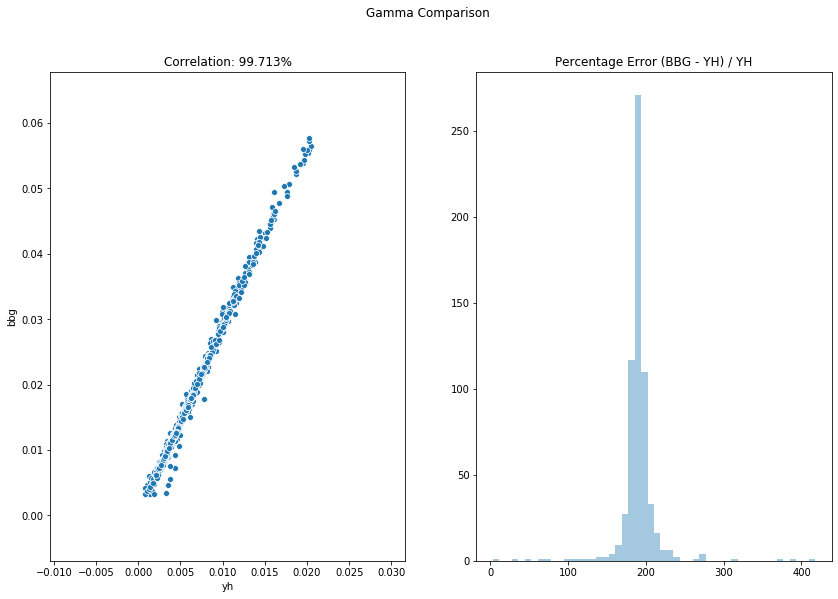

In [48]:
f, ax = plt.subplots(1, 2, figsize=(14, 9))
f.suptitle(f"{item} Comparison")

sns.scatterplot(x='yh', y='bbg', data=tmp, ax=ax[0])
ax[0].set_title(f"Correlation: {round(100 * tmp.yh.corr(tmp.bbg), 3)}%")

sns.distplot(100 * tmp.diff(axis=1).bbg / tmp.yh, kde=False, ax=ax[1])
ax[1].set_title("Percentage Error (BBG - YH) / YH")
plt.savefig("plots/gamma_comparison.png")

### Theta

In [49]:
cols = ['theta', 'THETA_LAST']
item = "Theta"

tmp = df[cols]
tmp.columns = ['yh', 'bbg']
tmp = tmp.dropna()

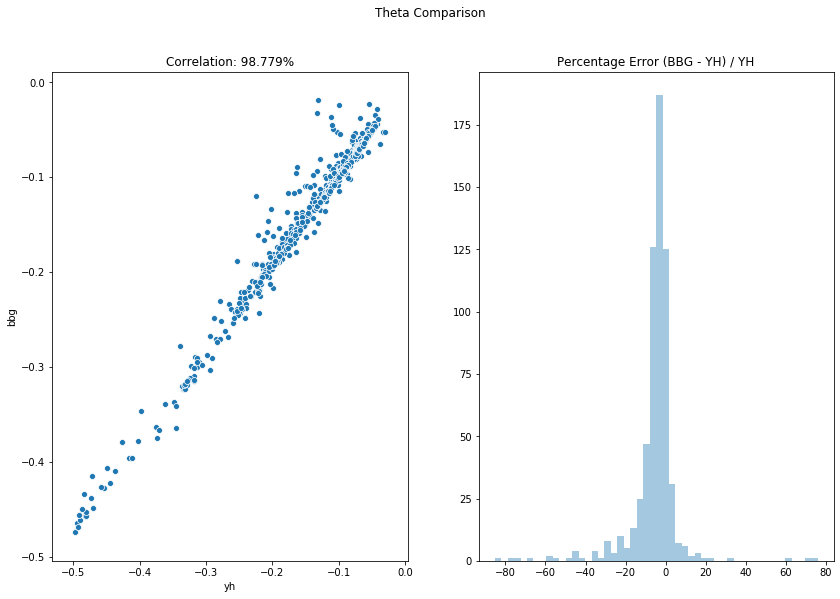

In [50]:
f, ax = plt.subplots(1, 2, figsize=(14, 9))
f.suptitle(f"{item} Comparison")

sns.scatterplot(x='yh', y='bbg', data=tmp, ax=ax[0])
ax[0].set_title(f"Correlation: {round(100 * tmp.yh.corr(tmp.bbg), 3)}%")

sns.distplot(100 * tmp.diff(axis=1).bbg / tmp.yh, kde=False, ax=ax[1])
ax[1].set_title("Percentage Error (BBG - YH) / YH")
plt.savefig("plots/theta_comparison.png")